In [3]:
import pyabc
import scipy
import numpy as np
from datetime import datetime
import pandas as pd

path = '../../results'
output_path = '../../figures'

file_name = 'basic-prior'

history = pyabc.History("sqlite:///{0}/{1}/{1}.db".format(path,file_name))
history.get_all_populations()

,t,population_end_time,samples,epsilon,particles
0,-1,2021-12-29 04:47:34.853143,200,inf,1
1,0,2021-12-29 10:54:43.770932,393,0.746575,200
2,1,2021-12-29 11:53:27.456808,4967,0.360622,836
3,2,2021-12-29 13:38:29.537354,9109,0.197467,1059
4,3,2021-12-29 16:37:20.673694,16125,0.145762,1111
5,4,2021-12-29 21:50:47.240188,27629,0.131083,964
6,5,2021-12-30 08:00:52.829615,53803,0.126588,982


In [30]:
def sample_from_kde(file_name, size=50_000, t=None):
    history = pyabc.History("sqlite:///{0}/{1}/{1}.db".format(path, file_name))
    samples, weights = history.get_distribution(m=0, t=None)
    kde = scipy.stats.gaussian_kde(samples.T.values.tolist(),weights=weights)
    kdesamples = kde.resample(2*size).T
    kdesamples = pd.DataFrame(data=kdesamples,columns=['mutation rate', 'trisomy rate', '2n+1 fitness', '2n+1* fitness', '2n* fitness'])
    order_criteria = (kdesamples['2n+1 fitness'] < kdesamples['2n+1* fitness']) & (kdesamples['2n+1* fitness'] < kdesamples['2n* fitness'])
    kdesamples = kdesamples[(kdesamples['mutation rate']>1e-9) & (kdesamples['mutation rate']<1e-5) &
              (kdesamples['trisomy rate']>1e-6) & (kdesamples['mutation rate']<1e-2) & order_criteria][:size]
    return kdesamples, kde

In [31]:
samples, kde = sample_from_kde(file_name, 100_000)
samples = pd.DataFrame(data=samples.values, columns=['μ', 'δ', 'w2n+1', 'w2n+1*', 'w2n*'])
samples.head()

,μ,δ,w2n+1,w2n+1*,w2n*
0,5.605658e-06,0.002444,1.022444,1.023879,1.027950
1,6.190136e-06,0.002721,1.021958,1.024054,1.027446
2,1.844528e-06,0.001584,1.020536,1.026020,1.026601
3,1.999214e-07,0.001503,1.021251,1.026140,1.027898
4,5.846199e-06,0.002858,1.025310,1.025629,1.030688


In [29]:
len(samples)

100000

In [32]:
samples.to_csv('posterior_samples.csv')

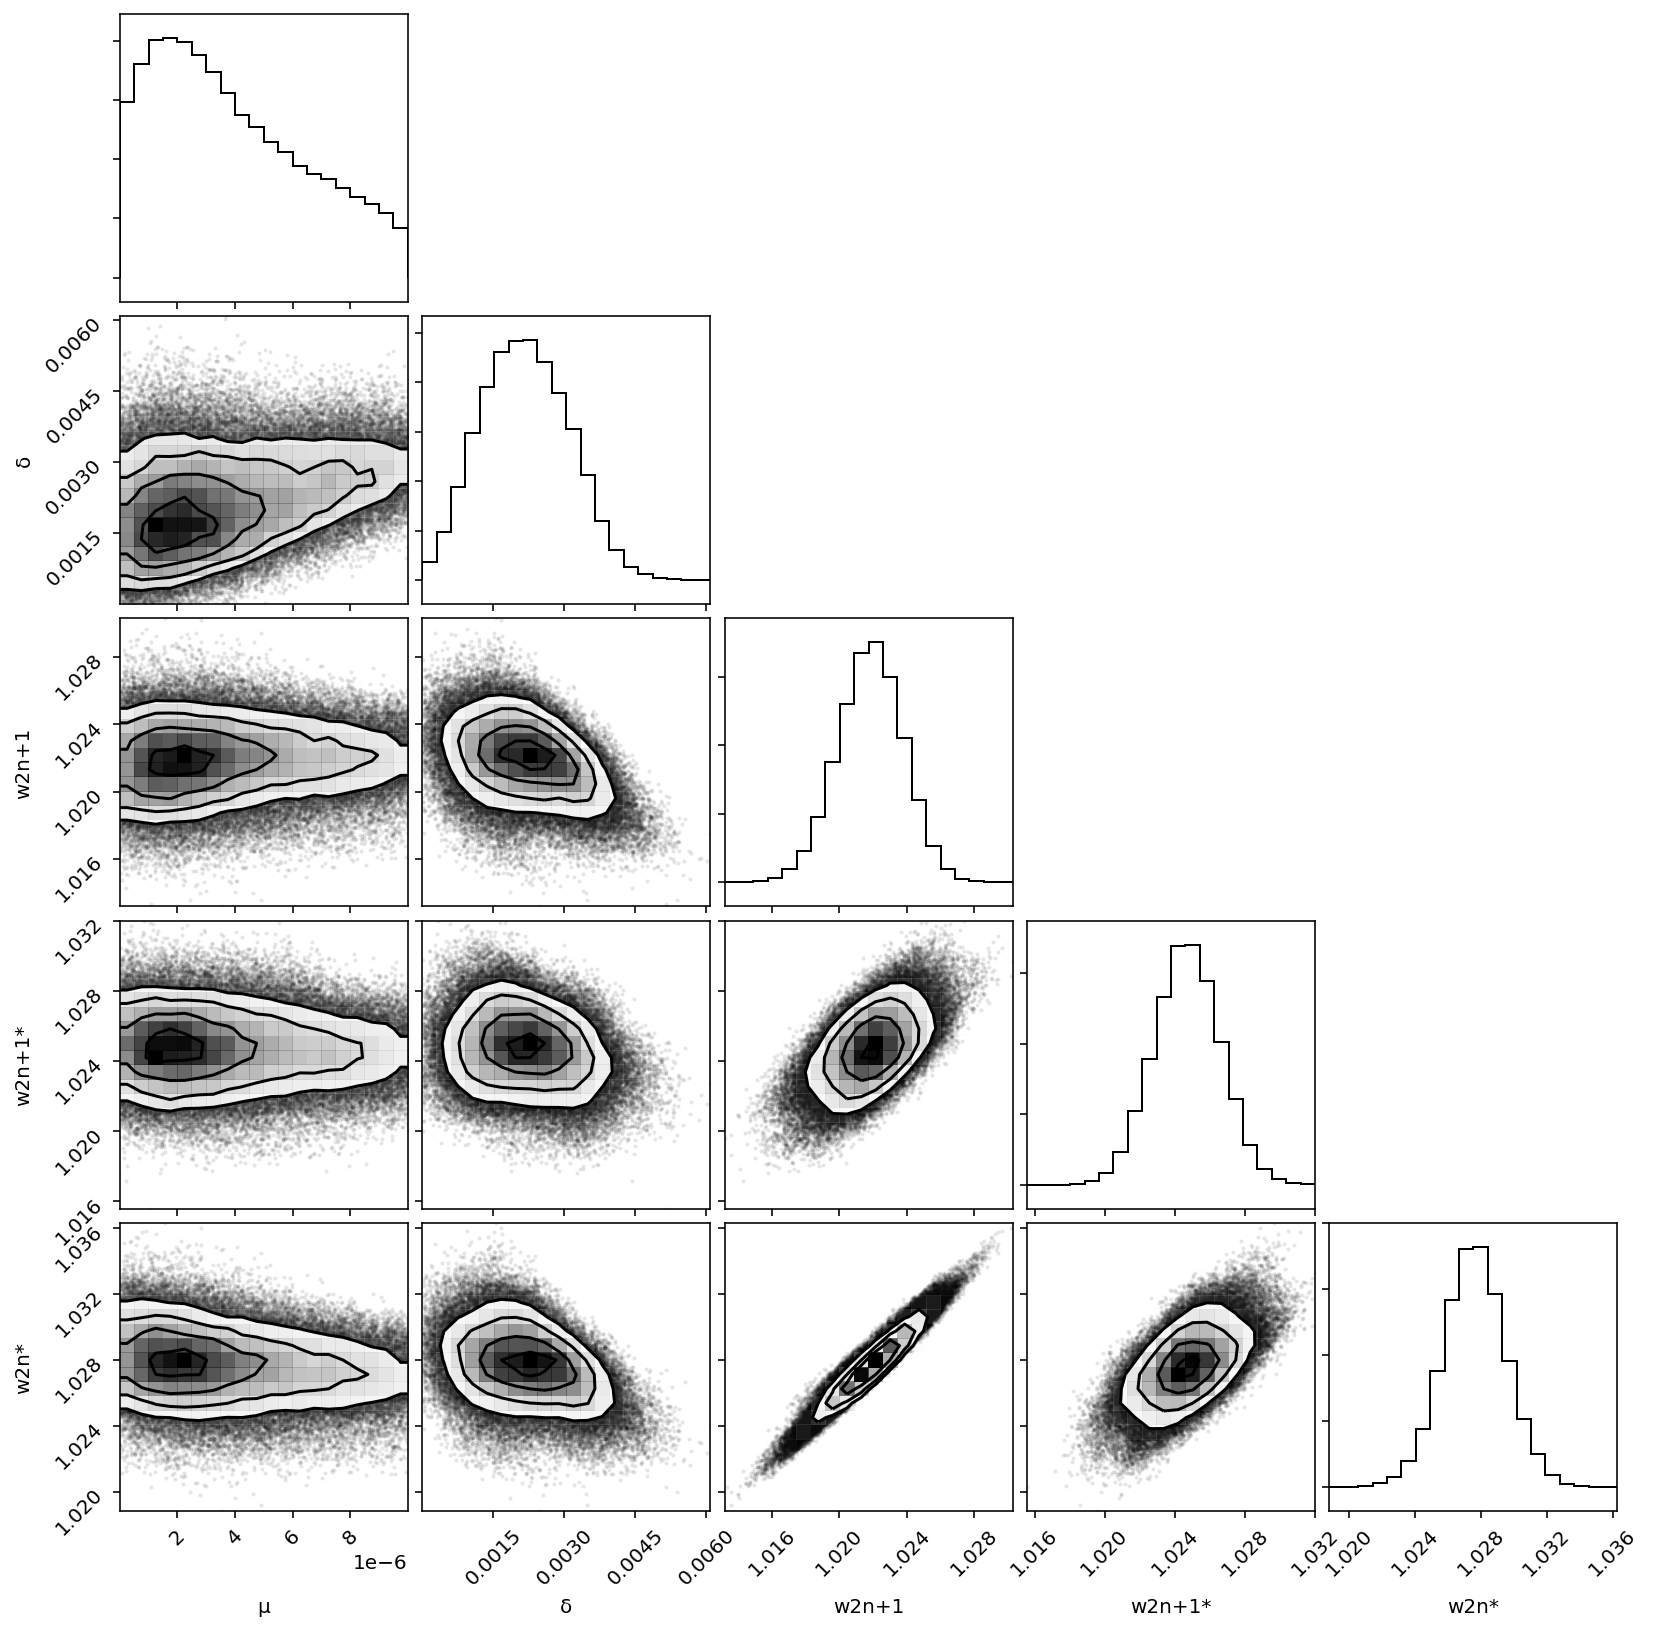

In [12]:
import corner
fig = corner.corner(samples, scale_hist=True)
